# First Principles View

Large Language Models (LLMs) appear to reason, but it's hard to prove if they are doing _math_ (Bayesian Inference) or just _mimicry_ (statistical pattern matching) because natural language is messy and lacks a ground truth and no "correct" probability distribution. 

Bayes' theorem is the mathematical foundation for updating beliefs in light of new evidence. It emerges naturally from the basic rules of probability. Bayes' theorem states:

```
P(H|E) = P(E|H) * P(H) / P(E)
```

Where:
- `P(H|E)` is the **posterior probability** - our updated belief about hypothesis H after seeing evidence E
- `P(E|H)` is the **likelihood** - how probable the evidence E is if the hypothesis H is true
- `P(H)` is the **prior probability** - our initial belief about H before seeing evidence E
- `P(E)` is the **marginal likelihood** - the total probability of seeing evidence E under all possible hypothesis

There is an expanded form of the same equation:

```
P((H|E) = P(E|H) * P(H) / ∑ P(E|H')P(H')
```
The key insight: P(E) equals that summation, P(E) is the summation of all probabilities of that evidence E where each Hypothesis H'
contributes some weight by how likely that hypothesis contributes to the evidence.

The authors of the "The Bayesian Geometry of Transformer Attention" paper Aggarwal et al introduce **"Bayesian Wind Tunnels"** - synthetic, controlled tasks (like Bijection Learning and HMM State Tracking) where the exact Bayesian posterior can be calculated mathematically. Small Transformers trained on these tasks don't just approximate; they **exactly reproduce** the analytic Bayesian posterior (to $10^{-3}$ bits, while MLPs fail. The peper shows that for *specific* classes of tasks (Discrete HMMs, Permutations), the Transformer architecture naturally converges to an algorithm that implements exact Bayesian updates. The "Self-Attention + MLP" block is isomorphic to a "Retrieval Evidence + Update Belief" step.





## Derivation from First principles
Bayes' theorem comes from the definition of conditional probability:
1. P(H|E) = P(H ∩ E) / P(E) [definition of conditional probability]
2. P(E|H) = P(E ∩ H) / P(H) [same conditional probability, reversed for evidence]
3. Therefore, P(H ∩ E) = P(E|H) * P(H)
4. Substituting into (1), P(H|E) = P(E|H) * P(H) / P(E)

_Translation_: The probability of H given E is the probability of both happening together (H ∩ E) divided by the probability of the condition evidence E happening at all. The probability of evidence E given Hypothesis H is reverse definition and note that the intersection of H and E happening together is the same, P(H ∩ E) = P(E ∩ H)

### Prior, Likelihood, Posterior

**Prior P(H): Starting Belief**
* Represents what you believe before seeing new data
* Can be informed by previous experience or domain knowledge
* In the absense of domain knowledge, or information, set to uniform distribution (principle of indifference)
* Example: "Before flipping this coin, I believe it has a 50% chance of being fair"

**Likelihood P(E|H): How well the Hypothesis explains the Data**
* Measures how consistent the observed evidence is with each hypothesis
* NOT a probability over hypotheses - it's a function of the data given a fixed hypothesis
* Example: "If this coin is fair, the probability of seeing 10 heads in a row is $(1/2)^10$

**Posterior P(H|E): Updated Belief**
* Combines prior knowledge with new evidence
* Represents rational belief after incorporating all available information, posterior from one analysis becomes prior for the next
* Example: "After seeing 10 heads in a row, I now believe there's a 95% chance the coin is biased"




In [3]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

np.random.seed(137) # nod to fine-structure constant α
torch.manual_seed(137);


In [5]:
def print_section(title: str):
    """ Print a formatted section header. """
    print("\n" + "=" * 70)
    print(f" {title}")
    print("=" * 70)



In [13]:
def example_bayesian_coin_flip():
    """
    Example: Learn Bayesian inference through a coin flip example.
    Scenario: You have a coin that might be fair (50/50) or biased (70% heads).
    You flip it several times and want to know: which coin is it?
    """
    print_section("Example: Bayesian Coin Flip")
    print("""
    You have two possible coins:
     - Fair Coin: P(Heads) = 0.5
     - Biased Coin: P(Heads) = 0.7
    Observation: H, H, H, T, H, (4 Heads, 1 Tail)
    Question: What's the probability each coin is the real one?
    """)

    # Define prior hypotheses
    # H1: Fair coin, H2: Biased coin
    prior_fair = 0.5 #P(H1)
    prior_biased = 0.5 #P(H2)
    print(f" Prior for Fair and Biased Coin:")
    print(f" \tP(Fair Coin) = {prior_fair}")
    print(f" \tP(Biased Coin) = {prior_biased}")

    # Observations
    n_heads, n_tails = 4, 1

    # Likelihood
    likelihood_fair = (0.5 ** n_heads) * (0.5 ** n_tails) # P(4H, 1T|Fair) 
    likelihood_biased = (0.7 ** n_heads) * (0.3 ** n_tails) # P(4H, 1T|Biased)

    print(f" P(Evidence | Hypothesis):")
    print(f" \tP(Data | Fair) = {likelihood_fair:.6f}")
    print(f" \tP(Data | Biased) = {likelihood_biased:.6f}")
    print(f" \tLikelihood Ratio = {likelihood_biased/likelihood_fair:.2f}x more likely under biased")

    # Marginal Likelihood P(E) - normalizing constant
    # P(E) = sum over all hypotheses P(E|H) * P(H)
    marginal = likelihood_fair * prior_fair + likelihood_biased * prior_biased
    print(f" P(E) = {marginal:.6f}")

    # Apply Bayes' theorem
    posterior_fair = likelihood_fair * prior_fair / marginal
    posterior_biased = likelihood_biased * prior_biased / marginal
    print(f" P(Fair | Data) = {posterior_fair:.6f}")
    print(f" P(Biased | Data) = {posterior_biased:.6f}")

    # Outcome
    print(f"After {n_heads} heads and {n_tails} tails:")
    print(f"\t{posterior_fair*100:.1f}% chance it's a fair coin")
    print(f"\t{posterior_biased*100:.1f}% chance it's a biased coin")
    
    #verify probailities
    assert abs(posterior_biased + posterior_fair - 1.0) < 1e-10

example_bayesian_coin_flip()    
    
    



 Example: Bayesian Coin Flip

    You have two possible coins:
     - Fair Coin: P(Heads) = 0.5
     - Biased Coin: P(Heads) = 0.7
    Observation: H, H, H, T, H, (4 Heads, 1 Tail)
    Question: What's the probability each coin is the real one?
    
 Prior for Fair and Biased Coin:
 	P(Fair Coin) = 0.5
 	P(Biased Coin) = 0.5
 P(Evidence | Hypothesis):
 	P(Data | Fair) = 0.031250
 	P(Data | Biased) = 0.072030
 	Likelihood Ratio = 2.30x more likely under biased
 P(E) = 0.051640
 P(Fair | Data) = 0.302576
 P(Biased | Data) = 0.697424
After 4 heads and 1 tails:
	30.3% chance it's a fair coin
	69.7% chance it's a biased coin


Observation: H Posterior Fair: 0.4167 Posterior Biased: 0.5833
Observation: H Posterior Fair: 0.3378 Posterior Biased: 0.6622
Observation: T Posterior Fair: 0.4596 Posterior Biased: 0.5404
Observation: H Posterior Fair: 0.3779 Posterior Biased: 0.6221
Observation: H Posterior Fair: 0.3026 Posterior Biased: 0.6974
Observation: H Posterior Fair: 0.2366 Posterior Biased: 0.7634
Observation: T Posterior Fair: 0.3406 Posterior Biased: 0.6594
Observation: H Posterior Fair: 0.2695 Posterior Biased: 0.7305
Observation: H Posterior Fair: 0.2086 Posterior Biased: 0.7914
Observation: H Posterior Fair: 0.1584 Posterior Biased: 0.8416
Observation: H Posterior Fair: 0.1185 Posterior Biased: 0.8815
Observation: T Posterior Fair: 0.1831 Posterior Biased: 0.8169
Observation: H Posterior Fair: 0.1380 Posterior Biased: 0.8620
Observation: H Posterior Fair: 0.1026 Posterior Biased: 0.8974


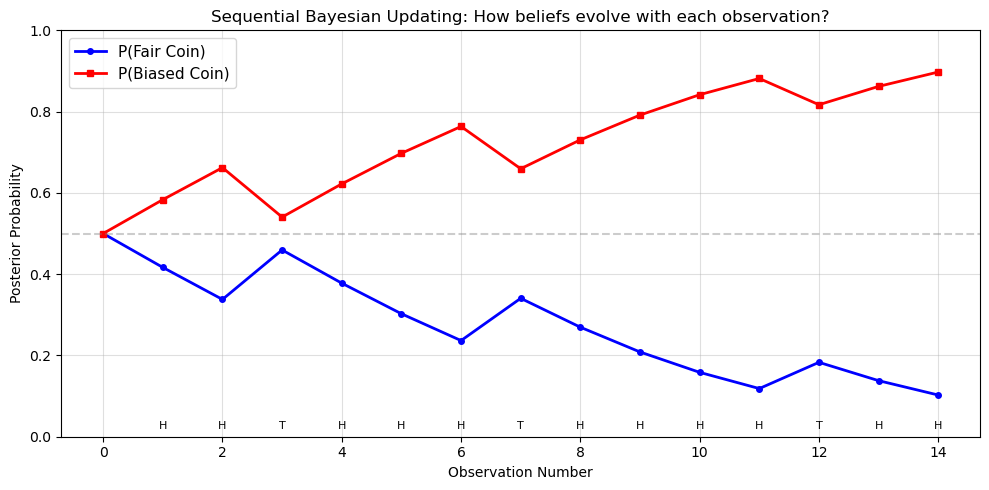

In [18]:
def example_bayesian_sequential_belief_update():
    """
    Shows how beliefs update incrementally with each new observation. This applies to
    how transformers process sequences as well.
    """

    # sequence of observations
    observations = [ 'H', 'H', 'T', 'H', 'H', 'H', 'T', 'H', 'H', 'H', 'H', 'T', 'H', 'H' ]

    beliefs_fair = [0.5]
    beliefs_biased = [0.5]

    current_prior_fair = 0.5
    current_prior_biased = 0.5

    for i, obs in enumerate(observations):
        if obs == 'H':
            like_fair = 0.5
            like_biased = 0.7
        else:
            like_fair = 0.5
            like_biased = 0.3

        unnorm_fair = like_fair * current_prior_fair
        unnorm_biased = like_biased * current_prior_biased
        normalizer = unnorm_biased + unnorm_fair

        posterior_fair = unnorm_fair / normalizer
        posterior_biased = unnorm_biased / normalizer

        print(f"Observation: {obs} Posterior Fair: {posterior_fair:.4f} Posterior Biased: {posterior_biased:.4f}")
        current_prior_fair = posterior_fair
        current_prior_biased = posterior_biased
        beliefs_fair.append(posterior_fair)
        beliefs_biased.append(posterior_biased)

    fig, ax = plt.subplots(figsize=(10,5))
    x = range(len(beliefs_fair))
    ax.plot(x, beliefs_fair, 'b-o', label='P(Fair Coin)', linewidth=2, markersize=4)
    ax.plot(x, beliefs_biased, 'r-s', label='P(Biased Coin)', linewidth=2, markersize=4)
    ax.axhline(y=0.5, color='gray', linestyle="--", alpha=0.4)
    ax.set_xlabel('Observation Number', fontsize=10)
    ax.set_ylabel('Posterior Probability', fontsize=10)
    ax.set_title('Sequential Bayesian Updating: How beliefs evolve with each observation?', fontsize=12)
    ax.legend(fontsize=11)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.4)
    # Add observation labels
    for i, obs in enumerate(observations):
        ax.annotate(obs, (i+1, 0.02), ha='center', fontsize=8)
    plt.savefig('sequential_bayesian_belief_update.png')
    plt.tight_layout()
    plt.show()

example_bayesian_sequential_belief_update()

Number of possible codes (hypotheses): 24

Initial entropy: log2(24) = 4.58 bits
Observation 1: A -> 3
	Remaining Hypotheses: 6
	Entropy: log2(6) = 2.58 bits
	Uncertainity reduced by: 2.00 bits
Observation 2: C -> 4
	Remaining Hypotheses: 2
	Entropy: log2(2) = 1.00 bits
	Uncertainity reduced by: 1.58 bits
Observation 3: B -> 1
	Remaining Hypotheses: 1
	Entropy: log2(1) = 0.00 bits
	Uncertainity reduced by: 1.00 bits
Only one hypothesis remains: {'A': 3, 'B': 1, 'C': 4, 'D': 2}
Entropy: 0 bits - completely certain


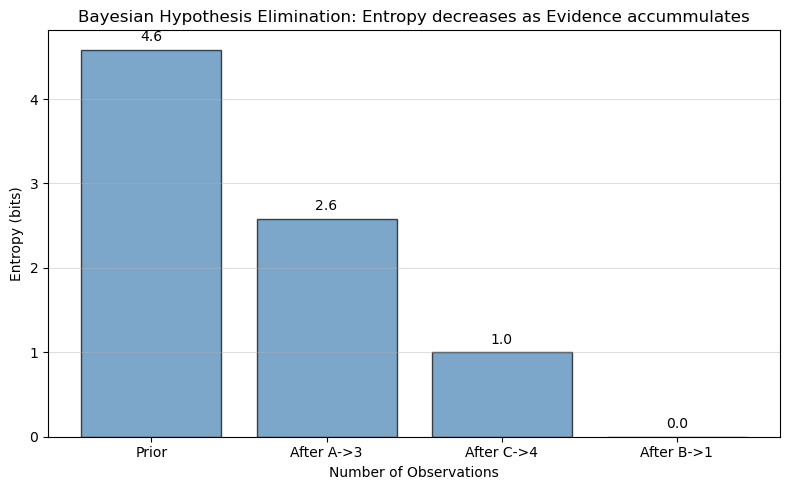

In [27]:
def example_discrete_hypothesis_elimination():
    """
    Shows learning a random mapping and referred in the paper as the bijection
    task. Imagine a secret code mapping letters to numbers:
    A -> ?, B -> > ?, C-> ?, D -> ? with some permutation of 1,2,3,4
    Observe examples and predict the next mapping - Initially there are 4! options
    Each observation eliminates possibilities.
    """
    letters = ['A', 'B', 'C', 'D']
    numbers = [ 1, 2, 3, 4 ]

    # Ground truth
    secret_code = { 'A': 3, 'B':1, 'C': 4, 'D': 2 }

    from itertools import permutations
    all_hypothesis = list(permutations(numbers))
    print(f"Number of possible codes (hypotheses): {len(all_hypothesis)}")

    # observations revealed one by one
    observations = [ ('A', 3), ('C', 4), ('B', 1) ]

    #track hypothesis space
    remaining_hypothesis = list(all_hypothesis)
    entropies = [np.log2(len(remaining_hypothesis))] # initial entopy

    print(f"\nInitial entropy: log2({len(remaining_hypothesis)}) = {entropies[0]:.2f} bits")
    for i, (letter, number) in enumerate(observations):
        letter_idx = letters.index(letter)

        # Filter: keep only hypotheses consistent with observation
        remaining_hypothesis = [
            h for h in remaining_hypothesis 
            if h[letter_idx] == number
        ]

        entropy = np.log2(max(1, len(remaining_hypothesis)))
        entropies.append(entropy)

        print(f"Observation {i+1}: {letter} -> {number}")
        print(f"\tRemaining Hypotheses: {len(remaining_hypothesis)}")
        print(f"\tEntropy: log2({len(remaining_hypothesis)}) = {entropy:.2f} bits")
        print(f"\tUncertainity reduced by: {entropies[-2] - entropy:.2f} bits")

    # With 3 prior observations, only 1 hypothesis should remain.
    if len(remaining_hypothesis) == 1:
        d_idx = letters.index('D')
        predicted_d = remaining_hypothesis[0][d_idx]
        print(f"Only one hypothesis remains: {dict(zip(letters, remaining_hypothesis[0]))}")
        print(f"Entropy: 0 bits - completely certain")
    else:
        d_idx = letters.index('D')
        possible_d = set(h[d_idx] for h in remaining_hypothesis)
        print(f"Possible values of D: {possible_d}")
        print(f"Each equally likely: P = 1/{len(possible_d)} = {1/len(possible_d):.2f}")

    # visualize entropy reduction
    fig, ax = plt.subplots(figsize=(8,5))
    x = range(len(entropies))
    ax.bar(x, entropies, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Number of Observations', fontsize=10)
    ax.set_ylabel('Entropy (bits)', fontsize=10)
    ax.set_title('Bayesian Hypothesis Elimination: Entropy decreases as Evidence accummulates', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(['Prior', 'After A->3', 'After C->4', 'After B->1'])
    ax.grid(True, alpha=0.4, axis='y')
    for i, e in enumerate(entropies):
        ax.annotate(f'{e:.1f}', (i, e+0.1), ha='center', fontsize=10)
    plt.tight_layout()
    plt.savefig('bayesian_hypothesis_elimination.png')
    plt.show()
    
    
        
example_discrete_hypothesis_elimination()    

Initial Entropy (26!): 88.38 bits
Obs 1: Remaining 25 unknown letters. Entropy: 83.68 bits (Reduced by 4.70)
Obs 2: Remaining 24 unknown letters. Entropy: 79.04 bits (Reduced by 4.64)
Obs 3: Remaining 23 unknown letters. Entropy: 74.45 bits (Reduced by 4.58)
Obs 4: Remaining 22 unknown letters. Entropy: 69.93 bits (Reduced by 4.52)
Obs 5: Remaining 21 unknown letters. Entropy: 65.47 bits (Reduced by 4.46)
Obs 6: Remaining 20 unknown letters. Entropy: 61.08 bits (Reduced by 4.39)
Obs 7: Remaining 19 unknown letters. Entropy: 56.76 bits (Reduced by 4.32)
Obs 8: Remaining 18 unknown letters. Entropy: 52.51 bits (Reduced by 4.25)
Obs 9: Remaining 17 unknown letters. Entropy: 48.34 bits (Reduced by 4.17)
Obs 10: Remaining 16 unknown letters. Entropy: 44.25 bits (Reduced by 4.09)
Obs 11: Remaining 15 unknown letters. Entropy: 40.25 bits (Reduced by 4.00)
Obs 12: Remaining 14 unknown letters. Entropy: 36.34 bits (Reduced by 3.91)
Obs 13: Remaining 13 unknown letters. Entropy: 32.54 bits (Redu

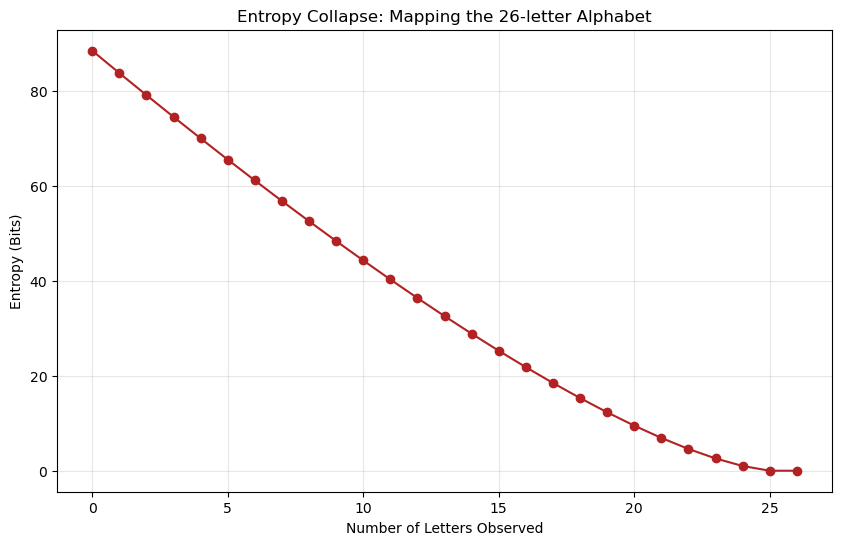

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import math

def simulate_alphabet_entropy():
    # 1. Initial State: 26! possibilities
    n = 26
    total_permutations = math.factorial(n)
    
    # Calculate initial entropy: log2(26!)
    # Using math.log2 on factorials can overflow, so we use the property:
    # log(n!) = log(1) + log(2) + ... + log(n)
    entropies = []
    current_log_val = sum(np.log2(i) for i in range(1, n + 1))
    entropies.append(current_log_val)
    
    print(f"Initial Entropy (26!): {entropies[0]:.2f} bits")
    
    # 2. Simulate observing 25 letters one by one
    # Each observation 'k' reduces the possibilities to (n-k)!
    for k in range(1, n):
        # Remaining entropy is log2((26-k)!)
        remaining_n = n - k
        entropy = sum(np.log2(i) for i in range(1, remaining_n + 1))
        entropies.append(entropy)
        
        reduction = entropies[-2] - entropies[-1]
        print(f"Obs {k}: Remaining {remaining_n} unknown letters. Entropy: {entropy:.2f} bits (Reduced by {reduction:.2f})")

    # Final state: 0 bits (1! = 1, log2(1) = 0)
    entropies.append(0) 

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(entropies, marker='o', color='firebrick')
    plt.title("Entropy Collapse: Mapping the 26-letter Alphabet")
    plt.xlabel("Number of Letters Observed")
    plt.ylabel("Entropy (Bits)")
    plt.grid(True, alpha=0.3)
    plt.show()

simulate_alphabet_entropy()